## 1. Download, Explore, and Prepare Santander Customer Satisfaction Dataset

In [22]:
SEED                    = 12345   # global random seed for better reproducibility
GLM_SELECTION_THRESHOLD = 0.000003 # threshold above which a GLM coefficient is considered "selected" 0.0001

In [25]:
from rmltk import explain, evaluate, model                        # simple module for training, explaining, and eval
import h2o                                                        # import h2o python bindings to h2o java server
import numpy as np                                                # array, vector, matrix calculations
import operator                                                   # for sorting dictionaries
import pandas as pd                                               # DataFrame handling
import time                                                       # for timers

import matplotlib.pyplot as plt      # plotting
pd.options.display.max_columns = 999 # enable display of all columns in notebook

# enables display of plots in notebook
%matplotlib inline

np.random.seed(SEED)                     # set random seed for better reproducibility

h2o.init(max_mem_size='24G', nthreads=4) # start h2o with plenty of memory and threads
h2o.remove_all()                         # clears h2o memory
h2o.no_progress()                        # turn off h2o progress indicators    

In [1]:
# import packages needed
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from vecstack import stacking
from sklearn import tree
from sklearn import metrics
from sklearn import ensemble
from sklearn import linear_model 
from sklearn import naive_bayes 
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

In [3]:
import time 
big_tic = time.time()

In [58]:
# import csv files
import os
os.chdir("D:\Machine learning-project")
path0 = 'train.csv'
path1 = 'test.csv'
train = pd.read_csv(path0) # skip the first row of the spreadsheet
test = pd.read_csv(path1) 

In [59]:
# rename some variables 
train_id = train['ID']
test_id = test["ID"]
train.drop('ID', axis=1, inplace = True)
test.drop('ID',axis=1,inplace = True)
train = train.rename(columns={'var3': 'Nationality'}) 
train = train.rename(columns={'num_var4': 'number of bank products'}) 
train = train.rename(columns={'var15': 'age'}) 

#### Remove the constant features

In [60]:
remove = []
for col in train.columns:
    if train[col].std() == 0:
        remove.append(col)

train.drop(remove, axis=1, inplace=True)
test.drop(remove, axis=1, inplace=True)

In [61]:
train.shape

(76020, 336)

#### Remove the duplicate features

In [62]:
remove = []
cols = train.columns
for i in range(len(cols)-1):
    v = train[cols[i]].values
    for j in range(i+1,len(cols)):
        if np.array_equal(v,train[cols[j]].values):
            remove.append(cols[j])
train.drop(remove, axis=1, inplace=True)
test.drop(remove, axis=1, inplace=True)

In [63]:
train.shape

(76020, 307)

#### Display descriptive statistics

In [34]:
train.head()

,Nationality,age,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var25_0,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32_0,ind_var33_0,ind_var33,ind_var34_0,ind_var37_cte,ind_var37_0,ind_var39_0,ind_var40_0,ind_var40,ind_var41_0,ind_var44_0,ind_var44,num_var1_0,num_var1,number of bank products,num_var5_0,num_var5,num_var6_0,num_var6,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13_medio_0,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18_0,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var25_0,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var33_0,num_var33,num_var34_0,num_var35,num_var37_med_ult2,num_var37_0,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var42_0,num_var42,num_var44_0,num_var44,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var42,saldo_var44,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_reemb_var33_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_venta_var44_1y3,imp_amort_var18_ult1,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_reemb_var33_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10cte_ult1,ind_var9_cte_ult1,ind_var9_ult1,ind_var43_emit_ult1,ind_var43_recib_ult1,var21,num_aport_var13_hace3,num_aport_var13_ult1,num_aport_var17_hace3,num_aport_var17_ult1,num_aport_var33_hace3,num_aport_var33_ult1,num_var7_emit_ult1,num_var7_recib_ult1,num_compra_var44_hace3,num_compra_var44_ult1,num_ent_var16_ult1,num_var22_hace2,num_var22_hace3,num_var22_ult1,num_var22_ult3,num_med_var22_ult3,num_med_var45_ult3,num_meses_var5_ult3,num_meses_var8_ult3,num_meses_var12_ult3,num_meses_var13_corto_ult3,num_meses_var13_largo_ult3,num_meses_var13_medio_ult3,num_meses_var17_ult3,num_meses_var29_ult3,num_meses_var33_ult3,num_meses_var39_vig_ult3,num_meses_var44_ult3,num_op_var39_comer_ult1,num_op_var39_comer_ult3,num_op_var40_comer_ult1,num_op_var40_comer_ult3,

In [35]:
train.describe()

,Nationality,age,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var25_0,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32_0,ind_var33_0,ind_var33,ind_var34_0,ind_var37_cte,ind_var37_0,ind_var39_0,ind_var40_0,ind_var40,ind_var41_0,ind_var44_0,ind_var44,num_var1_0,num_var1,number of bank products,num_var5_0,num_var5,num_var6_0,num_var6,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13_medio_0,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18_0,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var25_0,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var33_0,num_var33,num_var34_0,num_var35,num_var37_med_ult2,num_var37_0,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var42_0,num_var42,num_var44_0,num_var44,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var42,saldo_var44,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_reemb_var33_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_venta_var44_1y3,imp_amort_var18_ult1,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_reemb_var33_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10cte_ult1,ind_var9_cte_ult1,ind_var9_ult1,ind_var43_emit_ult1,ind_var43_recib_ult1,var21,num_aport_var13_hace3,num_aport_var13_ult1,num_aport_var17_hace3,num_aport_var17_ult1,num_aport_var33_hace3,num_aport_var33_ult1,num_var7_emit_ult1,num_var7_recib_ult1,num_compra_var44_hace3,num_compra_var44_ult1,num_ent_var16_ult1,num_var22_hace2,num_var22_hace3,num_var22_ult1,num_var22_ult3,num_med_var22_ult3,num_med_var45_ult3,num_meses_var5_ult3,num_meses_var8_ult3,num_meses_var12_ult3,num_meses_var13_corto_ult3,num_meses_var13_largo_ult3,num_meses_var13_medio_ult3,num_meses_var17_ult3,num_meses_var29_ult3,num_meses_var33_ult3,num_meses_var39_vig_ult3,num_meses_var44_ult3,num_op_var39_comer_ult1,num_op_var39_comer_ult3,num_op_var40_comer_ult1,num_op_var40_comer_ult3,

## 2. Investigate Pair-wise Pearson Correlations for `TARGET`
We applied Pearson correlation here to understand relationship between input features and the predicted target

#### Calculate Pearson correlation
categorical variables are not selected for correlation calculation

In [36]:
# assign target and inputs for models
y_name = 'TARGET'
x_names = [name for name in train.columns if name in [ 'imp_ent_var16_ult1', 'imp_op_var39_comer_ult1', 'imp_op_var39_comer_ult3', 'imp_op_var40_comer_ult1', 'imp_op_var40_comer_ult3', 'imp_op_var40_efect_ult1', 'imp_op_var40_efect_ult3', 'imp_op_var40_ult1', 'imp_op_var41_comer_ult1', 'imp_op_var41_comer_ult3', 'imp_op_var41_efect_ult1', 'imp_op_var41_efect_ult3', 'imp_op_var41_ult1', 'imp_op_var39_efect_ult1', 'imp_op_var39_efect_ult3', 'imp_op_var39_ult1', 'saldo_var1', 'saldo_var5', 'saldo_var8', 'saldo_var12', 'saldo_var13_corto', 'saldo_var13_largo', 'saldo_var13_medio', 'saldo_var14', 'saldo_var17', 'saldo_var20', 'saldo_var24', 'saldo_var26', 'saldo_var25', 'saldo_var30', 'saldo_var31', 'saldo_var32', 'saldo_var33', 'saldo_var37', 'saldo_var40', 'saldo_var42', 'saldo_var44', 'delta_imp_amort_var34_1y3', 'delta_imp_aport_var13_1y3', 'delta_imp_compra_var44_1y3', 'imp_aport_var13_hace3', 'imp_aport_var13_ult1', 'imp_aport_var17_hace3', 'imp_aport_var17_ult1', 'imp_aport_var33_hace3', 'imp_var7_recib_ult1', 'imp_compra_var44_hace3', 'imp_compra_var44_ult1', 'imp_reemb_var13_ult1', 'imp_reemb_var17_ult1', 'imp_var43_emit_ult1', 'imp_trans_var37_ult1', 'imp_venta_var44_ult1', 'var21', 'saldo_var2_ult1', 'saldo_medio_var5_hace2', 'saldo_medio_var5_hace3', 'saldo_medio_var5_ult1', 'saldo_medio_var5_ult3', 'saldo_medio_var8_hace2', 'saldo_medio_var8_hace3', 'saldo_medio_var8_ult1', 'saldo_medio_var8_ult3', 'saldo_medio_var12_hace2', 'saldo_medio_var12_hace3', 'saldo_medio_var12_ult1', 'saldo_medio_var12_ult3', 'saldo_medio_var13_corto_hace2', 'saldo_medio_var13_corto_hace3', 'saldo_medio_var13_corto_ult1', 'saldo_medio_var13_corto_ult3', 'saldo_medio_var13_largo_hace2', 'saldo_medio_var13_largo_hace3', 'saldo_medio_var13_largo_ult1', 'saldo_medio_var13_largo_ult3', 'saldo_medio_var17_hace2', 'saldo_medio_var17_hace3', 'saldo_medio_var17_ult1', 'saldo_medio_var17_ult3', 'saldo_medio_var33_hace2', 'saldo_medio_var33_hace3', 'saldo_medio_var33_ult1', 'saldo_medio_var33_ult3', 'saldo_medio_var44_hace2', 'saldo_medio_var44_hace3', 'saldo_medio_var44_ult1', 'saldo_medio_var44_ult3', 'var38' ]]
print('y_name =', y_name)
print('x_names =', x_names)

y_name = TARGET
x_names = ['imp_ent_var16_ult1', 'imp_op_var39_comer_ult1', 'imp_op_var39_comer_ult3', 'imp_op_var40_comer_ult1', 'imp_op_var40_comer_ult3', 'imp_op_var40_efect_ult1', 'imp_op_var40_efect_ult3', 'imp_op_var40_ult1', 'imp_op_var41_comer_ult1', 'imp_op_var41_comer_ult3', 'imp_op_var41_efect_ult1', 'imp_op_var41_efect_ult3', 'imp_op_var41_ult1', 'imp_op_var39_efect_ult1', 'imp_op_var39_efect_ult3', 'imp_op_var39_ult1', 'saldo_var1', 'saldo_var5', 'saldo_var8', 'saldo_var12', 'saldo_var13_corto', 'saldo_var13_largo', 'saldo_var13_medio', 'saldo_var14', 'saldo_var17', 'saldo_var20', 'saldo_var24', 'saldo_var26', 'saldo_var25', 'saldo_var30', 'saldo_var31', 'saldo_var32', 'saldo_var33', 'saldo_var37', 'saldo_var40', 'saldo_var42', 'saldo_var44', 'delta_imp_amort_var34_1y3', 'delta_imp_aport_var13_1y3', 'delta_imp_compra_var44_1y3', 'imp_aport_var13_hace3', 'imp_aport_var13_ult1', 'imp_aport_var17_hace3', 'imp_aport_var17_ult1', 'imp_aport_var33_hace3', 'imp_var7_recib_ult1', 

In [37]:
# Pearson correlation between inputs and target
# is last column of correlation matrix
corr_0 = pd.DataFrame(train[x_names + [y_name]].corr()[y_name]).iloc[:-1]
corr_0.columns = ['Pearson Correlation Coefficient']
corr_0

,Pearson Correlation Coefficient
imp_ent_var16_ult1,-0.000017
imp_op_var39_comer_ult1,0.010353
imp_op_var39_comer_ult3,0.003517
imp_op_var40_comer_ult1,0.003119
imp_op_var40_comer_ult3,-0.000358
...,...
saldo_medio_var44_hace2,-0.003177
saldo_medio_var44_hace3,-0.002553
saldo_medio_var44_ult1,-0.003104
saldo_medio_var44_ult3,-0.003015


## Select most correlated features with TARGET

In [38]:
corr = corr_0[abs(corr_0['Pearson Correlation Coefficient'] )> 0.02]
corr

,Pearson Correlation Coefficient
imp_op_var41_efect_ult1,0.029479
imp_op_var41_efect_ult3,0.021486
imp_op_var41_ult1,0.027586
imp_op_var39_efect_ult1,0.030380
imp_op_var39_efect_ult3,0.022172
imp_op_var39_ult1,0.027416
saldo_var12,-0.021882
saldo_var13_corto,-0.025843
saldo_var24,-0.021568
saldo_var30,-0.037092


In [39]:
x_names_sel = [name for name in train.columns if name in [ 'imp_op_var41_efect_ult1','imp_op_var41_efect_ult3','imp_op_var41_ult1','imp_op_var39_efect_ult1','imp_op_var39_efect_ult3 ','imp_op_var39_ult1', 'saldo_var12 ','saldo_var13_corto','saldo_var24','saldo_var30', 'saldo_var42', 'imp_aport_var13_hace3', 'saldo_medio_var5_hace2', 'saldo_medio_var12_ult1', 'saldo_medio_var12_ult3', 'saldo_medio_var13_corto_hace2', 'saldo_medio_var13_corto_ult1', 'saldo_medio_var13_corto_ult3' ]]

#### Plot Pearson correlation

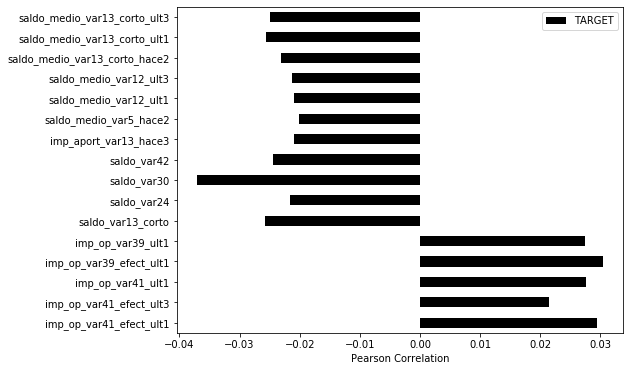

In [40]:
# display correlation to target as barchart
fig, ax_ = plt.subplots(figsize=(8, 6))
_ = pd.DataFrame(train[x_names_sel + [y_name]].corr()[y_name]).iloc[:-1].plot(kind='barh', ax=ax_, colormap='gnuplot')
_ = ax_.set_xlabel('Pearson Correlation')

In [41]:
corr_col = ['imp_op_var41_efect_ult1','imp_op_var41_efect_ult3','imp_op_var41_ult1','imp_op_var39_efect_ult1','imp_op_var39_efect_ult3 ','imp_op_var39_ult1', 'saldo_var12 ','saldo_var13_corto','saldo_var24','saldo_var30', 'saldo_var42', 'imp_aport_var13_hace3', 'saldo_medio_var5_hace2', 'saldo_medio_var12_ult1', 'saldo_medio_var12_ult3', 'saldo_medio_var13_corto_hace2', 'saldo_medio_var13_corto_ult1', 'saldo_medio_var13_corto_ult3' ]

## 3. Feature selection

#### Train penalized GLM for initial benchmark and feature selection 

#### Split data into training and validation partitions

In [14]:
split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(train)) < split_ratio
train1 = train[split]
valid = train[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train1.shape[0], train1.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

Train data rows = 53155, columns = 336
Validation data rows = 22865, columns = 336


In [15]:
# train penalized GLM w/ alpha and lambda grid search
best_glm = model.glm_grid(x_names_sel, y_name, h2o.H2OFrame(train),
                          h2o.H2OFrame(valid), SEED)

# output results
print('Best penalized GLM AUC: %.2f' % 
      best_glm.auc(valid=True))

# print selected coefficients
print('Best penalized GLM coefficients:')
for c_name, c_val in sorted(best_glm.coef().items(), key=operator.itemgetter(1)):
    if abs(c_val) > GLM_SELECTION_THRESHOLD:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val))

Best penalized GLM AUC: 0.62
Best penalized GLM coefficients:
Intercept:                -3.133160225918174
saldo_medio_var5_hace2:   -1.9700310306598116e-05
saldo_var30:              -7.659475271926196e-06
imp_aport_var13_hace3:    -6.117729198844957e-06
imp_op_var41_ult1:        2.3571026379712422e-05
imp_op_var39_ult1:        4.5449658652606534e-05
imp_op_var39_efect_ult1:  6.204117602834191e-05


In [16]:
# collect regularization paths from dict in DataFrame
reg_path_dict = best_glm.getGLMRegularizationPath(best_glm)
reg_path_frame = pd.DataFrame(columns=reg_path_dict['coefficients'][0].keys())
for i in range(0, len(reg_path_dict['coefficients'])): 
    reg_path_frame = reg_path_frame.append(reg_path_dict['coefficients'][i], 
                                           ignore_index=True)

    
# establish benchmark feature selection: glm_selected 
glm_selected = list(reg_path_frame.iloc[-1, :][reg_path_frame.iloc[-1, :] > GLM_SELECTION_THRESHOLD].index)


In [17]:
# collect Pearson correlation and GLM coefficients into same DataFrame
glm_selected_coef = pd.DataFrame.from_dict(best_glm.coef(), orient='index', columns=['Penalized GLM Coefficient'])
corr_glm = pd.concat([corr, glm_selected_coef.iloc[1:]], axis=1)

C:\Users\wenji\Downloads\Anaconda 3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


#### Remove quasi-constant features

The features with standard deviation value less than 0.1 may have little impact in predicting TARGET, so we will remove them as one of the feature selection method.

In [47]:
X_train = train.drop(["TARGET"],axis=1)
y_train = train.TARGET.values

In [44]:
X_train.shape

(76020, 306)

In [42]:
x_stdq1 =  x_std<0.1
x_stdq2 = x_std[x_stdq1]
print(x_stdq2)

ind_var1                    0.061115
ind_var6_0                  0.009932
ind_var6                    0.005735
ind_var13_largo_0           0.099568
ind_var13_largo             0.098673
                              ...   
num_trasp_var17_out_ult1    0.021070
num_trasp_var33_in_hace3    0.027201
num_trasp_var33_in_ult1     0.034407
num_trasp_var33_out_ult1    0.012165
num_venta_var44_hace3       0.027202
Length: 69, dtype: float64


In [48]:
x_stdq3 = x_stdq2.to_dict()
list(X_train.columns) 
X_train_fs3c = list(set(list(X_train.columns) ) - set(x_stdq3.keys()))

In [49]:
X_train_fs3 = X_train[X_train_fs3c]
X_train_fs3.shape

(76020, 250)

#### Remove highly correlated features 

Usually, the good variables are highly correlated with the target, and uncorrelated among themselves. In this section, the features highly correlated with each other (correaltion value > 0.9) will be dropped.

In [51]:
import seaborn as sns

In [52]:
corr_matrix = X_train.corr()
print(corr_matrix)

                         Nationality       age  imp_ent_var16_ult1  \
Nationality                 1.000000 -0.004452            0.001868   
age                        -0.004452  1.000000            0.043722   
imp_ent_var16_ult1          0.001868  0.043722            1.000000   
imp_op_var39_comer_ult1     0.005989  0.094762            0.041221   
imp_op_var39_comer_ult3     0.006817  0.101177            0.034879   
...                              ...       ...                 ...   
saldo_medio_var44_hace2     0.000617  0.029180            0.002655   
saldo_medio_var44_hace3     0.000508  0.018884           -0.000612   
saldo_medio_var44_ult1      0.000738  0.032833            0.005055   
saldo_medio_var44_ult3      0.000778  0.033597            0.006590   
var38                       0.000071  0.006497            0.000007   

                         imp_op_var39_comer_ult1  imp_op_var39_comer_ult3  \
Nationality                             0.005989                 0.006817   
age  

In [53]:
 # Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

,Nationality,age,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var25_0,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32_0,ind_var33_0,ind_var33,ind_var34_0,ind_var37_cte,ind_var37_0,ind_var39_0,ind_var40_0,ind_var40,ind_var41_0,ind_var44_0,ind_var44,num_var1_0,num_var1,number of bank products,num_var5_0,num_var5,num_var6_0,num_var6,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13_medio_0,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18_0,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var25_0,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var33_0,num_var33,num_var34_0,num_var35,num_var37_med_ult2,num_var37_0,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var42_0,num_var42,num_var44_0,num_var44,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var42,saldo_var44,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_reemb_var33_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_venta_var44_1y3,imp_amort_var18_ult1,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_reemb_var33_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10cte_ult1,ind_var9_cte_ult1,ind_var9_ult1,ind_var43_emit_ult1,ind_var43_recib_ult1,var21,num_aport_var13_hace3,num_aport_var13_ult1,num_aport_var17_hace3,num_aport_var17_ult1,num_aport_var33_hace3,num_aport_var33_ult1,num_var7_emit_ult1,num_var7_recib_ult1,num_compra_var44_hace3,num_compra_var44_ult1,num_ent_var16_ult1,num_var22_hace2,num_var22_hace3,num_var22_ult1,num_var22_ult3,num_med_var22_ult3,num_med_var45_ult3,num_meses_var5_ult3,num_meses_var8_ult3,num_meses_var12_ult3,num_meses_var13_corto_ult3,num_meses_var13_largo_ult3,num_meses_var13_medio_ult3,num_meses_var17_ult3,num_meses_var29_ult3,num_meses_var33_ult3,num_meses_var39_vig_ult3,num_meses_var44_ult3,num_op_var39_comer_ult1,num_op_var39_comer_ult3,num_op_var40_comer_ult1,num_op_var40_comer_ult3,

In [54]:
# Find the feature columns with correlation greater than 0.9
high_cor = [column for column in upper.columns if any(upper[column] > 0.9)]
len(high_cor)

137

In [55]:
X_train_fs2 = list(set(list(X_train.columns) ) - set(high_cor))
X_train_fs2 = X_train[X_train_fs2]
X_train_fs2.shape

(76020, 169)

#### Regulization

In [57]:
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
import sklearn

In [58]:
# Lets scale the data so that is ready to be used for regularization
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [59]:
scaler.transform(X_train)

array([[ 3.90744048e-02, -7.88248631e-01, -5.33881045e-02, ...,
        -1.88169080e-02, -1.98468529e-02, -4.27182680e-01],
       [ 3.90744048e-02,  6.07525955e-02, -5.33881045e-02, ...,
        -1.88169080e-02, -1.98468529e-02, -3.72038298e-01],
       [ 3.90744048e-02, -7.88248631e-01, -5.33881045e-02, ...,
        -1.88169080e-02, -1.98468529e-02, -2.73191237e-01],
       ...,
       [ 3.90744048e-02, -7.88248631e-01, -5.33881045e-02, ...,
        -1.88169080e-02, -1.98468529e-02, -2.36542515e-01],
       [ 3.90744048e-02, -6.33884772e-01, -5.33881045e-02, ...,
        -1.88169080e-02, -1.98468529e-02, -1.80428318e-01],
       [ 3.90744048e-02,  9.86935752e-01, -5.33881045e-02, ...,
        -1.88169080e-02, -1.98468529e-02,  4.11519699e-04]])

In [62]:
sel=SelectFromModel(LogisticRegression(C=1,penalty='l2'))
sel.fit(scaler.transform(X_train),y_train)

C:\Users\Yue\Desktop\GWU Summer 2020\New folder\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


SelectFromModel(estimator=LogisticRegression(C=1))

In [63]:
sum(sel.get_support())

97

There are 97 features removed from regulization. Then we filter the dataset by removing the 116 features.

In [64]:
X_train_fs4 = list(set(list(X_train.columns) ) - set(X_train.columns[sel.get_support()]))
X_train_fs4 = X_train[X_train_fs4]
X_train_fs4.shape

(76020, 209)

In [65]:
X_test_fs4 = list(set(list(X_train.columns) ) - set(X_train.columns[sel.get_support()]))
X_test_fs4 = X_test[X_test_fs4]
X_test_fs4.shape

(15204, 209)

### Forward Step-wise Training

In [19]:
# initialize data structures needed to compare correlation coefficients,
# penalized glm coefficients, and MGBM Shapley values
# as features are added into the MGBM

# create a list of features to add into MGBM
# list is ordered by correlation between X_j and y
abs_corr = corr.copy(deep=True)
abs_corr['Pearson Correlation Coefficient'] = corr['Pearson Correlation Coefficient'].abs()


next_list = [name for name in list(abs_corr.sort_values(by='Pearson Correlation Coefficient',
                                                        ascending=False).index) if name not in glm_selected]

# create a DataFrame to store new MGBM SHAP values
# for comparison to correlation and penalized glm coefficients
abs_corr_glm_mgbm_shap = corr_glm.copy(deep=True).abs()
abs_corr_glm_mgbm_shap.columns = ['Absolute ' + name for name in abs_corr_glm_mgbm_shap.columns]
abs_corr_glm_mgbm_shap['Monotonic GBM Mean SHAP Value'] = 0

# start local timer
tic = time.time()

# forward stepwise MGBM training
mgbm_train_results = model.gbm_forward_select_train(glm_selected, 
                                                    y_name, 
                                                    train, 
                                                    valid, 
                                                    SEED, 
                                                    next_list,
                                                    abs_corr_glm_mgbm_shap, 
                                                    'Monotonic GBM Mean SHAP Value',
                                                    monotone=True)

mgbm_models = mgbm_train_results['MODELS']
corr_glm_mgbm_shap_coefs = mgbm_train_results['GLOBAL_COEFS']
mgbm_shap = mgbm_train_results['LOCAL_COEFS']

# end local timer
toc = time.time()-tic
print('Task completed in %.2f s.' % (toc))


Starting grid search 1/16 ...
Input features = ['imp_op_var41_ult1', 'imp_op_var39_efect_ult1', 'imp_op_var39_ult1']
Monotone constraints = {'imp_op_var41_ult1': 1, 'imp_op_var39_efect_ult1': 1, 'imp_op_var39_ult1': 1}
Completed grid search 1/16 with AUC: 0.51 ...
--------------------------------------------------------------------------------
Starting grid search 2/16 ...
Input features = ['imp_op_var41_ult1', 'imp_op_var39_efect_ult1', 'imp_op_var39_ult1', 'saldo_var30']
Monotone constraints = {'imp_op_var41_ult1': 1, 'imp_op_var39_efect_ult1': 1, 'imp_op_var39_ult1': 1, 'saldo_var30': -1}
Completed grid search 2/16 with AUC: 0.57 ...
--------------------------------------------------------------------------------
Starting grid search 3/16 ...
Input features = ['imp_op_var41_ult1', 'imp_op_var39_efect_ult1', 'imp_op_var39_ult1', 'saldo_var30', 'imp_op_var41_efect_ult1']
Monotone constraints = {'imp_op_var41_ult1': 1, 'imp_op_var39_efect_ult1': 1, 'imp_op_var39_ult1': 1, 'saldo_var30'

In [20]:
# autoph cv_model_rank_select function
# requires models to have model_id 
best_glm.model_id = 'best_glm'
compare_model_ids = ['best_glm'] # list of model_ids

# start local timer
tic = time.time()

# perform CV rank model selection
mgbm_rank_results = evaluate.cv_model_rank_select(valid,
                                                  SEED,
                                                  mgbm_train_results,
                                                  'mgbm',
                                                  compare_model_ids)

best_mgbm = mgbm_rank_results['BEST_MODEL']
best_mgbm_shap = mgbm_rank_results['BEST_LOCAL_COEFS']
mgbm_selected_coefs = mgbm_rank_results['BEST_GLOBAL_COEFS']
best_mgbm_eval = mgbm_rank_results['METRICS']

Evaluated model 1/16 with rank: 2.00 ...
Evaluated model 2/16 with rank: 1.68* ...
Evaluated model 3/16 with rank: 1.66* ...
Evaluated model 4/16 with rank: 1.68 ...
Evaluated model 5/16 with rank: 1.66 ...
Evaluated model 6/16 with rank: 1.68 ...
Evaluated model 7/16 with rank: 1.04* ...
Evaluated model 8/16 with rank: 1.66 ...
Evaluated model 9/16 with rank: 1.66 ...
Evaluated model 10/16 with rank: 1.66 ...
Evaluated model 11/16 with rank: 1.04 ...
Evaluated model 12/16 with rank: 1.04 ...
Evaluated model 13/16 with rank: 1.68 ...
Evaluated model 14/16 with rank: 1.06 ...
Evaluated model 15/16 with rank: 1.08 ...
Evaluated model 16/16 with rank: 1.06 ...
Done.


In [21]:
best_mgbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  mgbm7


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,201.0,201.0,18498.0,0.0,7.0,0.79602,1.0,16.0,2.393035




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.03761894899793077
RMSE: 0.19395604913982645
LogLoss: 0.16149372331020784
Mean Per-Class Error: 0.30987161575596434
AUC: 0.7048478819533892
AUCPR: 0.08607360186865123
Gini: 0.4096957639067784

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.047611261590847984: 


,,0,1,Error,Rate
0,0,52934.0,20078.0,0.275,(20078.0/73012.0)
1,1,1037.0,1971.0,0.3447,(1037.0/3008.0)
2,Total,53971.0,22049.0,0.2778,(21115.0/76020.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.047611,0.157321,250.0
1,max f2,0.047611,0.289164,250.0
2,max f0point5,0.047611,0.108054,250.0
3,max accuracy,0.767505,0.960431,1.0
4,max precision,0.767505,0.500000,1.0
5,max recall,0.004172,1.000000,393.0
6,max specificity,0.783209,0.999986,0.0
7,max absolute_mcc,0.047611,0.163357,250.0
8,max min_per_class_accuracy,0.044157,0.656250,257.0
9,max mean_per_class_accuracy,0.047611,0.690128,250.0



Gains/Lift Table: Avg response rate:  3.96 %, avg score:  4.05 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010024,0.081974,3.482446,3.482446,0.137795,0.166699,0.137795,0.166699,0.034907,0.034907,248.244576,248.244576
1,,2,0.020021,0.054120,2.061713,2.773013,0.081579,0.063336,0.109724,0.115085,0.020612,0.055519,106.171263,177.301266
2,,3,0.290042,0.047611,2.221064,2.259164,0.087884,0.047634,0.089392,0.052290,0.599734,0.655253,122.106406,125.916401
3,,4,0.566404,0.043386,0.553353,1.426859,0.021895,0.043418,0.056459,0.047961,0.152926,0.808178,-44.664673,42.685926
4,,5,0.817074,0.042053,0.518555,1.148200,0.020518,0.042053,0.045433,0.046148,0.129987,0.938165,-48.144474,14.820001
5,,6,0.900723,0.016126,0.492814,1.087335,0.019500,0.022135,0.043024,0.043918,0.041223,0.979388,-50.718616,8.733513
6,,7,1.000000,0.001544,0.207619,1.000000,0.008215,0.009568,0.039569,0.040508,0.020612,1.000000,-79.238087,0.000000




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.038040375569825126
RMSE: 0.19503942055344894
LogLoss: 0.16250270828721824
Mean Per-Class Error: 0.3066683617945667
AUC: 0.7108627005575094
AUCPR: 0.08840172962494487
Gini: 0.4217254011150189

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.047611290067170645: 


,,0,1,Error,Rate
0,0,26440.0,10105.0,0.2765,(10105.0/36545.0)
1,1,514.0,1012.0,0.3368,(514.0/1526.0)
2,Total,26954.0,11117.0,0.2789,(10619.0/38071.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.047611,0.160089,226.0
1,max f2,0.047611,0.293827,226.0
2,max f0point5,0.047611,0.110014,226.0
3,max accuracy,0.692173,0.959970,1.0
4,max precision,0.767505,1.000000,0.0
5,max recall,0.005909,1.000000,382.0
6,max specificity,0.767505,1.000000,0.0
7,max absolute_mcc,0.047611,0.166809,226.0
8,max min_per_class_accuracy,0.044168,0.663827,234.0
9,max mean_per_class_accuracy,0.047611,0.693332,226.0



Gains/Lift Table: Avg response rate:  4.01 %, avg score:  4.06 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010008,0.085218,3.535970,3.535970,0.141732,0.166320,0.141732,0.166320,0.035387,0.035387,253.596970,253.596970
1,,2,0.020042,0.053166,1.893976,2.713897,0.075916,0.063377,0.108781,0.114781,0.019004,0.054391,89.397563,171.389665
2,,3,0.292007,0.047611,2.238450,2.271081,0.089724,0.047626,0.091032,0.052235,0.608781,0.663172,123.844952,127.108118
3,,4,0.570881,0.043386,0.559261,1.434862,0.022417,0.043419,0.057514,0.047929,0.155963,0.819135,-44.073854,43.486189
4,,5,0.819548,0.042053,0.524421,1.158616,0.021020,0.042053,0.046441,0.046146,0.130406,0.949541,-47.557855,15.861627
5,,6,0.900948,0.016136,0.434722,1.093213,0.017425,0.022115,0.043819,0.043975,0.035387,0.984928,-56.527768,9.321256
6,,7,1.000000,0.001920,0.152164,1.000000,0.006099,0.009690,0.040083,0.040579,0.015072,1.000000,-84.783630,0.000000




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-06-23 04:31:34,47.987 sec,0.0,0.194943,0.166570,0.500000,0.039569,1.000000,0.960431,0.196155,0.168211,0.500000,0.040083,1.000000,0.959917
1,,2020-06-23 04:31:34,48.074 sec,1.0,0.194811,0.165953,0.566932,0.054086,3.262828,0.808603,0.196020,0.167567,0.572215,0.055234,3.304831,0.808831
2,,2020-06-23 04:31:34,48.157 sec,2.0,0.194698,0.165483,0.568100,0.054463,3.238595,0.808603,0.195907,0.167077,0.572405,0.055174,3.304831,0.808831
3,,2020-06-23 04:31:34,48.235 sec,3.0,0.194609,0.165134,0.577076,0.056449,3.213143,0.782320,0.195816,0.166702,0.582008,0.057261,3.396094,0.783457
4,,2020-06-23 04:31:34,48.314 sec,4.0,0.194534,0.164796,0.577235,0.056499,3.217650,0.782689,0.195737,0.166335,0.581806,0.057141,3.274046,0.783851
5,,2020-06-23 04:31:34,48.394 sec,5.0,0.194482,0.164555,0.577110,0.056466,3.345391,0.782676,0.195681,0.166069,0.581389,0.057094,3.274046,0.783851
6,,2020-06-23 04:31:34,48.472 sec,6.0,0.194446,0.164377,0.575515,0.056059,3.345391,0.784793,0.195643,0.165870,0.579440,0.056541,3.274046,0.785847
7,,2020-06-23 04:31:34,48.560 sec,7.0,0.194405,0.164190,0.575718,0.056108,3.345391,0.784846,0.195597,0.165652,0.579949,0.056789,3.274046,0.785847
8,,2020-06-23 04:31:34,48.639 sec,8.0,0.194374,0.164036,0.575642,0.056057,3.349781,0.785228,0.195562,0.165474,0.579661,0.056718,3.274046,0.786189
9,,2020-06-23 04:31:34,48.716 sec,9.0,0.194351,0.163915,0.575645,0.056034,3.349781,0.785228,0.195534,0.165322,0.579665,0.056697,3.405008,0.786189



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,saldo_var30,48.502777,1.000000,0.418408
1,saldo_var42,28.990509,0.597708,0.250086
2,imp_op_var41_efect_ult1,15.096548,0.311251,0.130230
3,imp_op_var39_efect_ult1,10.700185,0.220610,0.092305
4,imp_op_var39_ult1,9.053922,0.186668,0.078103
5,imp_op_var41_ult1,3.099582,0.063905,0.026738
6,saldo_medio_var13_corto_ult1,0.244711,0.005045,0.002111
7,saldo_medio_var13_corto_ult3,0.205623,0.004239,0.001774
8,saldo_var13_corto,0.028259,0.000583,0.000244


In [63]:
best_mgbm_var = ['saldo_var30','saldo_var42','imp_op_var41_efect_ult1','imp_op_var39_efect_ult1','imp_op_var39_ult1	','imp_op_var41_ult1','saldo_medio_var13_corto_ult1','saldo_medio_var13_corto_ult3','saldo_var13_corto']

In [65]:
len(best_mgbm_var)

9

#### using ExtraTrees Classifier to select certain important features

In [64]:
X = train.drop(["TARGET"],axis=1)
y = train.TARGET.values

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
print(X_train.shape, X_test.shape, test.shape)

(60816, 306) (15204, 306) (75818, 306)


In [66]:
clf = ensemble.ExtraTreesClassifier(random_state=1,n_estimators=100)
selector = clf.fit(X_train, y_train)

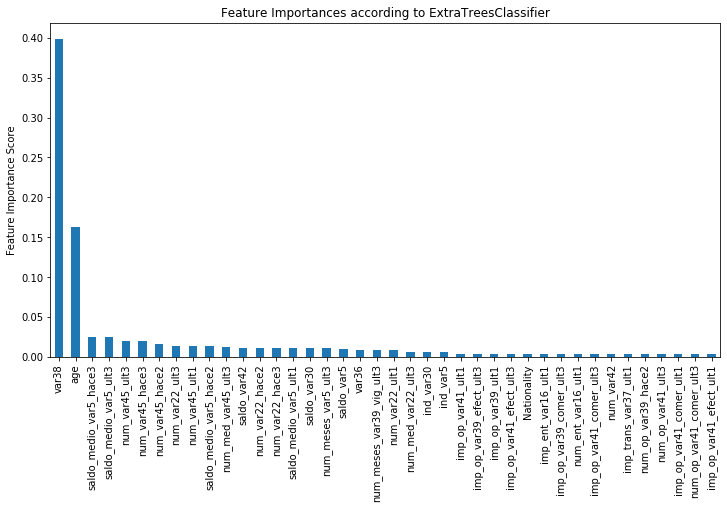

In [67]:
import matplotlib.pyplot as plt
feat_imp = pd.Series(clf.feature_importances_, index = X_train.columns.values).sort_values(ascending=False)
feat_imp[:40].plot(kind='bar', title='Feature Importances according to ExtraTreesClassifier', figsize=(12, 8))
plt.ylabel('Feature Importance Score')
plt.subplots_adjust(bottom=0.3)
plt.savefig('1.png')
plt.show()

In [68]:
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt

fs = SelectFromModel(selector, prefit=True)

X_train = fs.transform(X_train)
X_test = fs.transform(X_test)
test = fs.transform(test)

print(X_train.shape, X_test.shape, test.shape)
# then we have only 34 features.

(60816, 34) (15204, 34) (75818, 34)


#### Feature selection summary

fs2_col: 169 features, Remove highly correlated features

fs3_col: 250 features, Remove quasi-constant features 

fs4_col: 209 features, Regulization

fs6_col: 9 features, forward stepwise training - best mgbm

fs7_col: 18 features, Pearson correlation

fs9_col: 34 features, ExtraTree Classifier

In [79]:
fs2_col = list(set(list(X_train.columns) ) - set(high_cor))
fs3_col = list(set(list(X_train.columns) ) - set(x_stdq3.keys()))
fs4_col = list(set(list(X_train.columns) ) - set(X_train.columns[sel.get_support()]))
fs6_col = best_mgbm_var
fs7_col = corr_col

#### After trying different combinations of features, we found those 34 features perform the best, then we use those features to fit models. ####

## 4. Model Building

#### We tried several models ####

#### 1. XGB Classifier ####

In [16]:
model_xgb = xgb.XGBClassifier(n_estimators=550, nthread=4,learning_rate=0.03,reg_alpha = 0.03,min_child_weight=3, subsample=0.95,colsample_bytree=0.85, max_depth = 5, \
seed=4242)
model_xgb.fit(X_train, y_train, early_stopping_rounds=20, eval_metric="auc", verbose = False,
           eval_set=[(X_test, y_test)])

# calculate the auc score
print("Roc AUC: ", roc_auc_score(y_test, model_xgb.predict_proba(X_test)[:,1],
              average='macro'))

Roc AUC:  0.839295350292348


#### 2. ExtraTress Classifier ####

In [17]:
et = ensemble.ExtraTreesClassifier(n_estimators=80,bootstrap=True,random_state=0,max_depth=5)
et = et.fit(X_train,y_train)
print("Roc AUC: ", roc_auc_score(y_test, et.predict_proba(X_test)[:,1],
              average='macro'))

Roc AUC:  0.7563888772469867


#### 3. AdaBoost Classifier ####

In [18]:
abc = ensemble.AdaBoostClassifier(learning_rate = 0.363,random_state = 1)
abc = abc.fit(X_train,y_train)
print("Roc AUC: ", roc_auc_score(y_test, abc.predict_proba(X_test)[:,1],
              average='macro'))

Roc AUC:  0.8299910283525186


In [19]:
mydict={}
for i in np.linspace(0.35,0.37,10):
    abc = ensemble.AdaBoostClassifier(learning_rate = i)
    abc.fit(X_train,y_train)
    s = roc_auc_score(y_test, abc.predict_proba(X_test)[:,1],average='macro')
    mydict[i]=s
mydict

{0.35: 0.8293369238095984,
 0.3522222222222222: 0.8291753001310821,
 0.35444444444444445: 0.8292565662884808,
 0.35666666666666663: 0.8293610594608176,
 0.35888888888888887: 0.8295256362072476,
 0.3611111111111111: 0.8295766334185294,
 0.36333333333333334: 0.8299963665906707,
 0.3655555555555555: 0.8299925048864756,
 0.36777777777777776: 0.8299624063096612,
 0.37: 0.8298955647532263}

#### 4. Bagging Classifier ####

In [20]:
bag = ensemble.BaggingClassifier(n_jobs = -1,
                                n_estimators = 300,
                                warm_start=False,
                                oob_score=True,
                                max_samples = 200,
                                bootstrap=True,
                                random_state=42,
                                verbose=1)
bag.fit(X_train,y_train)
print("Roc AUC: ", roc_auc_score(y_test, bag.predict_proba(X_test)[:,1],
              average='macro'))

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.4s remaining:   13.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Roc AUC:  0.8021550126680933


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished


#### 5.RandomForest Classifier ####

In [21]:
rf = RandomForestClassifier(random_state=0, n_jobs=4, min_samples_split=2,min_samples_leaf=1,
                           n_estimators=3000, max_depth=15,oob_score=True)
rf.fit(X_train,y_train)
print("Roc AUC: ", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1],
              average='macro'))

Roc AUC:  0.8369926387967475


#### 6.GradientBoosting Classifier ####

In [22]:
gboost = ensemble.GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.049, loss='exponential', max_depth=3,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=348,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=True)
gboost.fit(X_train,y_train)
print("Roc AUC: ", roc_auc_score(y_test, gboost.predict_proba(X_test)[:,1],
              average='macro'))

D:\anaconda\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


Roc AUC:  0.8372775530606675


In [27]:
mydict = {}
for i in np.linspace(0.045,0.055,6):
    gboost = ensemble.GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=i, loss='exponential', max_depth=3,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=350,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=True)
    gboost.fit(X_train,y_train)
    s = roc_auc_score(y_test, gboost.predict_proba(X_test)[:,1],average='macro')
    mydict[i]=s
mydict

{0.045: 0.836022044879136,
 0.047: 0.8369863351325467,
 0.049: 0.8372630716699361,
 0.051000000000000004: 0.8367451489896589,
 0.053: 0.8363594896780622,
 0.055: 0.8365966437474522}

In [28]:
mydict = {}
for i in [340,343,345,348,350,351,352]:
    gboost = ensemble.GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.049, loss='exponential', max_depth=3,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=i,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=True)
    gboost.fit(X_train,y_train)
    s = roc_auc_score(y_test, gboost.predict_proba(X_test)[:,1],average='macro')
    mydict[i]=s
mydict

{340: 0.8371639167357515,
 343: 0.8372016251414208,
 345: 0.8371652229004055,
 348: 0.8372773259015971,
 350: 0.8372630716699361,
 351: 0.8372469433759449,
 352: 0.837190380767441}

In [26]:
stack = (abc.predict_proba(test)[:,1]*0.35 + model_xgb.predict_proba(test)[:,1]*0.3 + rf.predict_proba(test)[:,1]*0.2
        +gboost.predict_proba(test)[:,1]*0.15)
sub = pd.DataFrame()
sub['Id'] = test_id
sub['TARGET'] = stack
sub.to_csv('submission.csv',index=False)


#### Since the model xgb performs best, we tried to use only this model to predict the outcome.  ####

In [32]:
sub = pd.DataFrame()
sub['Id'] = test_id
sub['TARGET'] = model_xgb.predict_proba(test)[:,1]
sub.to_csv('submission_3_test_7.csv',index=False)


#### We also tried to combine certain good models, but the result do not perform better than the xgb modell.####

In [27]:
stack = (abc.predict_proba(test)[:,1]*0.35 + model_xgb.predict_proba(test)[:,1]*0.3 + rf.predict_proba(test)[:,1]*0.2
        +gboost.predict_proba(test)[:,1]*0.15)
sub = pd.DataFrame()
sub['Id'] = test_id
sub['TARGET'] = stack
sub.to_csv('submission.csv',index=False)

#### Therefore, we submitted submission_3_test_7_csv, and get a public score of 0.83740. ####

In [ ]:
h2o.cluster().shutdown(prompt=True)